In [5]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, FlaxAutoModelForCausalLM
from datasets import load_dataset

from basin_volume import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

# Tokenizer

In [6]:

tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1M")

In [10]:
len(tokenizer.vocab)

50257

# Dataset

In [4]:
ds = load_dataset("roneneldan/TinyStories")

In [ ]:
type(ds['train'])

datasets.arrow_dataset.Dataset

In [64]:
from transformers import AutoTokenizer
import torch
from datasets import Dataset
from typing import Union, List, Dict
import numpy as np

def tokenize_dataset_on_gpu(
    dataset: Dataset,
    tokenizer: Union[str, AutoTokenizer],
    text_column: str = "text",
    batch_size: int = 1000,
    max_length: int = 512,
    num_proc: int = 1,
    **tokenizer_kwargs
) -> Dataset:
    """
    Efficiently tokenize a HuggingFace dataset using GPU acceleration.
    
    Args:
        dataset: HuggingFace dataset to tokenize
        tokenizer: Tokenizer or pretrained model name
        text_column: Name of the column containing text to tokenize
        batch_size: Number of examples to process at once
        max_length: Maximum sequence length
        num_proc: Number of CPU processes for non-GPU operations
        **tokenizer_kwargs: Additional arguments to pass to the tokenizer
    
    Returns:
        Dataset: Tokenized dataset with new columns for input_ids, attention_mask, etc.
    """
    # Initialize tokenizer if string is provided
    if isinstance(tokenizer, str):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer)
    
    # Move tokenizer to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def tokenize_batch(examples: Dict[str, List]) -> Dict[str, List]:
        # Get text from the specified column
        texts = examples[text_column]
        
        # Tokenize on GPU
        encodings = tokenizer(
            texts,
            padding=True,
            return_tensors="pt",
            **tokenizer_kwargs
        ).to(device)
        
        # Convert to numpy arrays and move back to CPU
        return {
            "input_ids": encodings.input_ids.cpu().numpy(),
            "attention_mask": encodings.attention_mask.cpu().numpy(),
        }
    
    # Process the dataset in batches
    tokenized_dataset = dataset.map(
        tokenize_batch,
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        remove_columns=dataset.column_names,  # Remove original columns
        desc="Tokenizing on GPU"
    )
    
    return tokenized_dataset

In [67]:
print(tokenizer.pad_token_id)
print(tokenizer.eos_token_id)
print(tokenizer.bos_token_id)
print(tokenizer.unk_token_id)


None
50256
50256
50256


In [ ]:
# first 10 datapoints from Arrow dataset
first_ten = ds['train'][:10]
list(first_ten.keys())
summarize(first_ten)

{'type': dict,
 'size': 1,
 'contents': [{'key': 'text',
   'value': {'type': list,
    'size': 10,
    'contents': [{'type': str, 'size': 701},
     {'type': str, 'size': 705},
     {'type': str, 'size': 822},
     {'type': str, 'size': 845},
     {'type': str, 'size': 638},
     {'type': str, 'size': 657},
     {'type': str, 'size': 723},
     {'type': str, 'size': 750},
     {'type': str, 'size': 774},
     {'type': str, 'size': 596}]}}]}

In [ ]:
# list of lists
alltoks = [tokenizer.encode(x) for x in ds['train'][:1000]['text']]
# concatenated
catted = jnp.concatenate([jnp.array(x) for x in alltoks])
catted.shape


(234420,)

In [60]:
max(len(x) for x in ds['train']['text'])

5499

In [68]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [69]:
tokenized_dataset = tokenize_dataset_on_gpu(
    ds['train'],
    tokenizer,
    text_column="text",  # Change to your text column name
    batch_size=1000,       # Adjust based on your GPU memory
    max_length=5500       # Adjust based on your needs
)

Tokenizing on GPU:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Tokenizing on GPU: 100%|██████████| 2119719/2119719 [17:41<00:00, 1996.97 examples/s]


In [70]:
tokenized_dataset['input_ids'].shape

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f885ec2e8d0>>
Traceback (most recent call last):
  File "/opt/conda/envs/jax311/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
type(tokenized_dataset['input_ids'])

In [ ]:
len(set(catted.tolist()))

5340

# Model

In [11]:

model = FlaxAutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1M", from_pt=True)

Some weights of the model checkpoint at roneneldan/TinyStories-1M were not used when initializing FlaxGPTNeoForCausalLM: {('transformer', 'h', '3', 'attn', 'attention', 'bias'), ('transformer', 'h', '5', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '4', 'attn', 'attention', 'bias'), ('transformer', 'h', '3', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '4', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '1', 'attn', 'attention', 'bias'), ('transformer', 'h', '6', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '2', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '0', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '2', 'attn', 'attention', 'bias'), ('transformer', 'h', '0', 'attn', 'attention', 'bias'), ('transformer', 'h', '1', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '6', 'attn', 'attention', 'bias'), ('transformer', 'h', '5', 'attn', 'attention', 'bias'), ('transformer', 'h', '7', 'attn', 'attention'

## Trimming/untrimming embedding params

In [12]:
list(model.params['transformer'].keys())


['wte', 'wpe', 'h', 'ln_f']

In [18]:
def printdict(d, depth=0):
    for k, v in d.items():
        print(f"{'  ' * depth}{k}")
        if isinstance(v, dict):
            printdict(v, depth + 1)
        else:
            print(f"{'  ' * (depth + 1)}{v.shape}")

printdict(model.params)

transformer
  wte
    embedding
      (50257, 64)
  wpe
    embedding
      (2048, 64)
  h
    0
      ln_1
        scale
          (64,)
        bias
          (64,)
      attn
        attention
          k_proj
            kernel
              (64, 64)
          v_proj
            kernel
              (64, 64)
          q_proj
            kernel
              (64, 64)
          out_proj
            kernel
              (64, 64)
            bias
              (64,)
      ln_2
        scale
          (64,)
        bias
          (64,)
      mlp
        c_fc
          kernel
            (64, 256)
          bias
            (256,)
        c_proj
          kernel
            (256, 64)
          bias
            (64,)
    1
      ln_1
        scale
          (64,)
        bias
          (64,)
      attn
        attention
          k_proj
            kernel
              (64, 64)
          v_proj
            kernel
              (64, 64)
          q_proj
            kernel
              (64

emb.shape=(50257, 64)


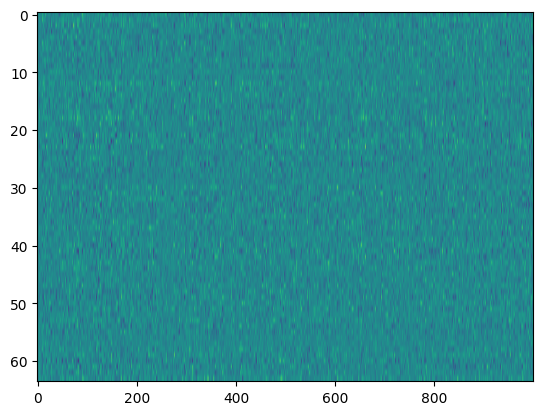

In [37]:
emb = model.params['transformer']['wte']['embedding']
print(f"{emb.shape=}")
plt.imshow((emb.T - emb.T.mean(axis=1).reshape(-1, 1))[:, 9500:10500], aspect='auto')

In [16]:
emb.shape

(50257, 64)

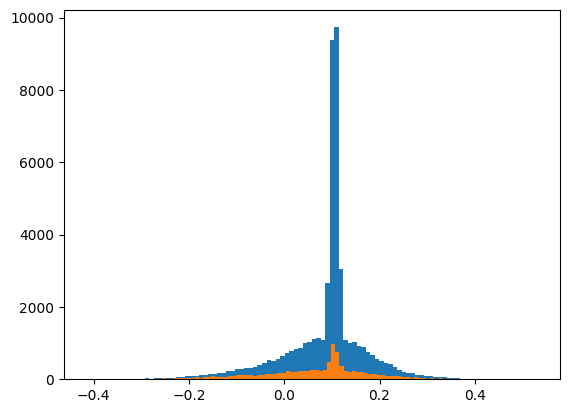

In [19]:
dim = 60
plt.hist(emb[:, dim], bins=100)
plt.hist(emb[:10_000, dim], bins=100)
plt.show()


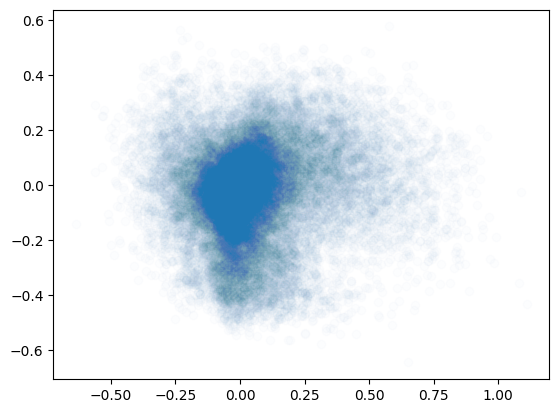

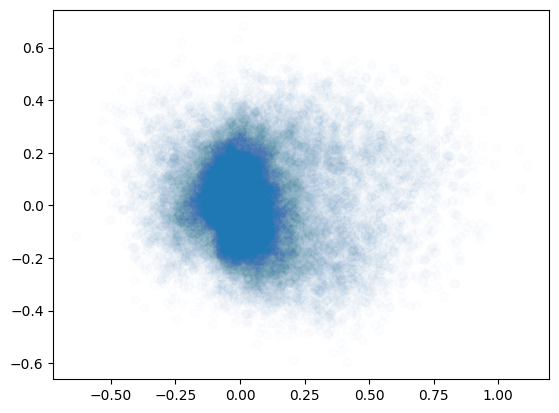

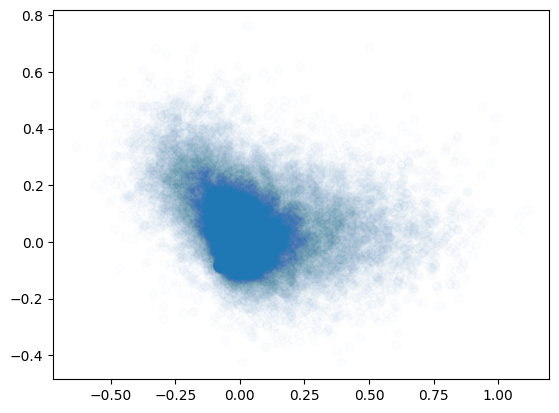

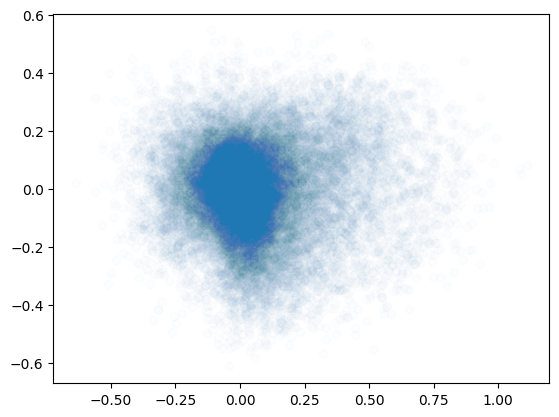

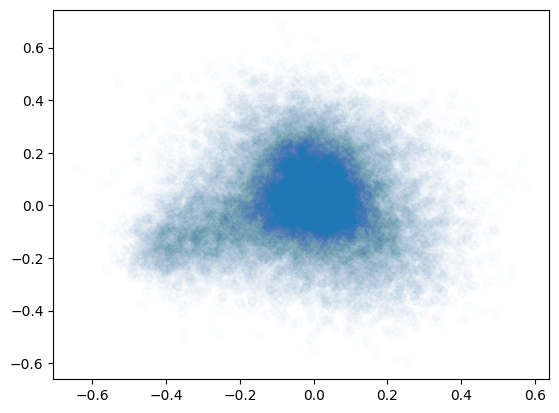

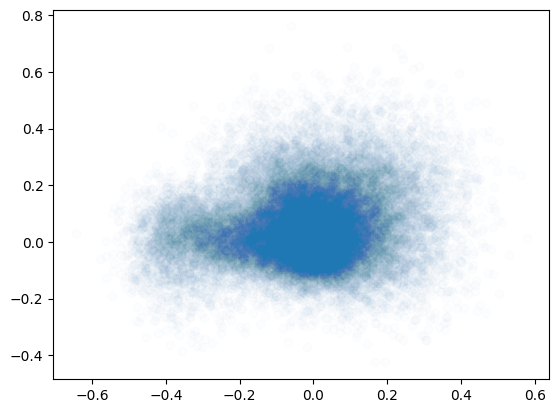

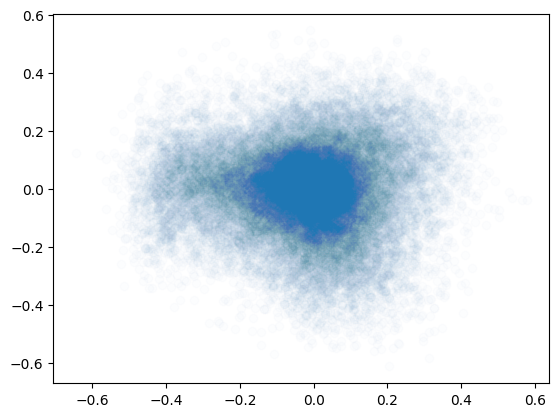

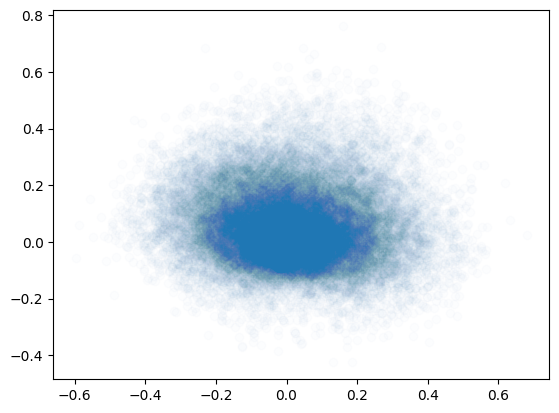

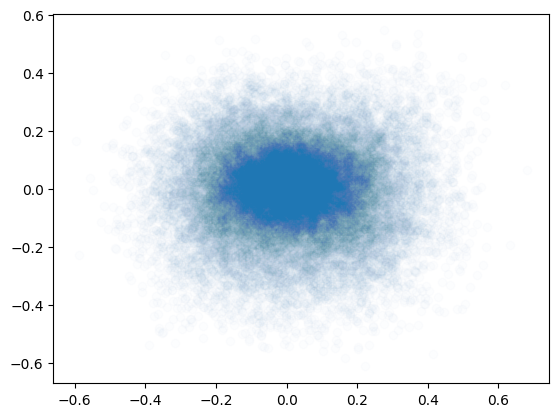

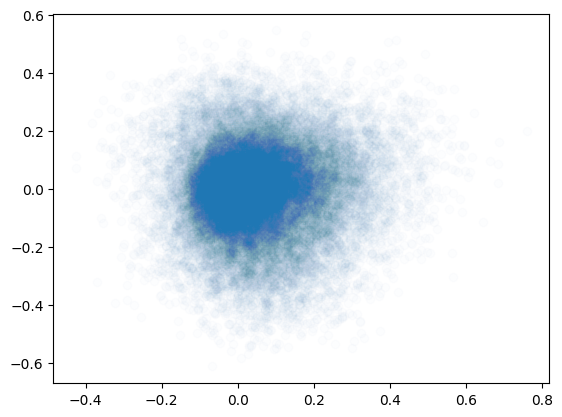

In [56]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(emb)
pca.explained_variance_ratio_
pca.components_
pca.transform(emb)
for i in range(5):
    for j in range(i+1, 5):
        plt.scatter(pca.transform(emb)[:, i], pca.transform(emb)[:, j], alpha=0.01)
        plt.show()

In [21]:
final_params.shape

(3745984,)

In [38]:
final_params = jax.flatten_util.ravel_pytree(model.params)[0]

In [39]:
# sample from the model
tokens = model.generate(tokenizer.encode("Once upon a time", return_tensors="jax"), max_length=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [40]:
print(tokenizer.decode(tokens.sequences[0]))

Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, shiny rock in the sky. She wanted to touch it, but it was too high.

Lily's mommy told her that it was important to be careful and not touch things. Lily didn't want to touch it, so she asked her mommy if she could touch it. Her mommy said yes and they went to the park


In [48]:
tokenizer.eos_token_id
tokenizer.bos_token_id

50256

In [49]:
# logits on empty input
logits = model(input_ids=jnp.array([[tokenizer.bos_token_id]]))


In [50]:
logits

FlaxMaskedLMOutput(logits=Array([[[ 5.7880588,  4.524547 , -1.4551396, ..., -6.075085 ,
          0.3338914, 10.264471 ]]], dtype=float32), hidden_states=None, attentions=None)

In [63]:
logits.logits[0,0,8222]

Array(4.877771, dtype=float32)

In [58]:
# top 100 logits
top_100 = jnp.argsort(logits.logits[0, 0, :])[-100:]
for i in top_100:
    print(i, tokenizer.decode(i))


526 ."
8222  forest
1639 You
1625  came
995  world
5615  lived
1686 aps
46980  Ding
33 B
3329  morning
286  of
2877  living
757  again
1026 It
1355  Be
397 ab
23676  Poor
15902  Hi
8396 berry
734  two
6155  walking
44 M
3932  Ben
3619  Jack
318  is
31824  Boom
4458 '.
423  have
820 day
2402  upon
17250 Hi
447 �
338 's
8471 ez
843  And
770  This
24975  Suddenly
10814 Hey
1439  All
4186  Tom
6 '
1867  What
679  He
47 P
1820 my
6766  sky
3952  park
5045  Tim
0 !
20037  Lily
1138  met
3862  Time
632  It
251 �
8348 ?'
2712  playing
44320 
 
301 st
40 I
3706  named
1320  That
11 ,
76 m
2735  Now
554  In
917 und
704 hed
7454 Once
317  A
290  and
2354  outside
262  the
8567 Look
382 ore
921  You
1701 ?"
16944 bird
258 he
257  a
66 c
416  by
3240  town
640  time
287  in
351  with
91 |
261 on
78 o
319  on
612  there
373  was
68 e
30 ?
383  The
13 .
1752  once
220  
50256 <|endoftext|>
198 

628 




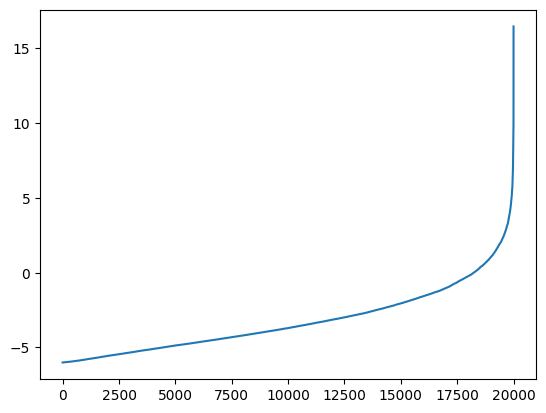

In [64]:
plt.plot(jnp.sort(logits.logits[0, 0, :])[-20000:])
plt.show()
